<a href="https://colab.research.google.com/github/isshii/de4test/blob/test_koyama/LIME_for_generated_input_from_DeepXprore_%E7%8A%AC%E7%8C%AB%E9%81%A9%E7%94%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 方針
* LIME にかけるモデルを、DeepXproreで使ってるモデルに変更する
* 摂動を加えた画像を読み込んで、それぞれのモデルがどう判断しているのかを見る

In [1]:
# ドライブをマウントする
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
data_dir = "/content/gdrive/My\ Drive/ColabNotebooks/test4ai/data"
data_imagenet_generated = "/content/gdrive/My\ Drive/ColabNotebooks/test4ai/data/ImageNet/generated_inputs/"
data_imagenet = "/content/gdrive/My\ Drive/ColabNotebooks/test4ai/data/ImageNet"
data_imagenet_seeds = "/content/gdrive/My\ Drive/ColabNotebooks/test4ai/data/ImageNet/seeds"
model_dir = "/content/gdrive/My\ Drive/ColabNotebooks/test4ai/model"
output_dir = "/content/gdrive/My\ Drive/ColabNotebooks/test4ai/output"
tmp_dir = "/content/gdrive/My\ Drive/ColabNotebooks/test4ai/tmp"

In [3]:
import argparse

%tensorflow_version 1.x
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.layers import Input
import imageio

class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

from keras import models
from keras import optimizers
from keras.models import model_from_json
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from collections import defaultdict

import numpy as np
from keras import backend as K
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.models import Model
from keras.preprocessing import image
import os, re

Using TensorFlow backend.


In [4]:
from keras_applications.imagenet_utils import preprocess_input as preprocess_input
import os, re
import random
import keras
# models
from keras.applications import inception_v3 as inc_net
from keras.applications import inception_resnet_v2 as inc_res

from keras.applications import resnet50 as resnet50
# from keras.applications.resnet50 import ResNet50
# from keras.applications.resnet50 import preprocess_input, decode_predictions

from keras.applications import vgg16 as vgg16

# from keras.applications.vgg16 import VGG16
# from keras.applications.vgg16 import preprocess_input

from keras.applications import vgg19 as vgg19
# from keras.applications.vgg19 import VGG19
# from keras.applications.vgg19 import preprocess_input

from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions

from keras.layers import Input

from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
print('Notebook run using keras:', keras.__version__)

Notebook run using keras: 2.2.5


In [5]:
img_rows, img_cols = 224, 224
# img_rows, img_cols = 299, 299
input_shape = (img_rows, img_cols, 3)

# define input tensor as a placeholder
input_tensor = Input(shape=input_shape)


モデルの設定
ここに「再学習前の誤判断モデル」「再学習後のモデル」を設定する

In [28]:
#######################
# モデルの設定
#######################
#model1 = vgg16.VGG16(input_tensor=input_tensor)
#model2 = vgg19.VGG19(input_tensor=input_tensor)
#model3 = resnet50.ResNet50(input_tensor=input_tensor)
model1 = VGG16(weights='imagenet',input_tensor=input_tensor,include_top=True)
for layers in (model1.layers)[:19]:
    print(layers)
    layers.trainable = False
X= model1.layers[-2].output
predictions1 = Dense(2, activation="softmax",name='model1_output')(X) #出力層のnameを追加
model1 = Model(input = model1.input, output = predictions1)
model1.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])
#vgg16_weights = model_dir + '/model2.ep12.h5'
vgg16_weights = '../content/drive/My Drive/ColabNotebooks/test4ai/model/model2.ep12.h5'

model1.load_weights(vgg16_weights)

model2 = VGG16(weights='imagenet',input_tensor=input_tensor,include_top=True)
for layers in (model2.layers)[:19]:
    print(layers)
    layers.trainable = False
X= model2.layers[-2].output
predictions2 = Dense(2, activation="softmax",name='model2_output')(X) #出力層のnameを追加
model2 = Model(input = model2.input, output = predictions2)
model2.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])
vgg16_weights = '../content/drive/My Drive/ColabNotebooks/test4ai/model/relearng_model_20200213_ep05.h5'
model2.load_weights(vgg16_weights)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("mo...)`
  import sys


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("mo...)`


In [0]:
def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
#        img = image.load_img(img_path, target_size=(299, 299))
        img = image.load_img(img_path, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
#        x = inc_net.preprocess_input(x)
#        x = vgg16.preprocess_input(x,mode='tf')
        x = vgg16.preprocess_input(x)
        plt.imshow(img)
        out.append(x)
    return np.vstack(out)

def transform_img_fn2(path_list):
    out = []
    for img_path in path_list:
#        img = image.load_img(img_path, target_size=(299, 299))
        img = image.load_img(img_path, target_size=(224, 224))
        plt.imshow(img)
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
#        x = inc_net.preprocess_input(x)
#        x = vgg16.preprocess_input(x,mode='tf')
        x = vgg16.preprocess_input(x)
        out.append(x)
    return np.vstack(out)


def list_pictures(directory, ext='jpg|jpeg|bmp|png|ppm'):
    return [os.path.join(root, f)
            for root, _, files in os.walk(directory) for f in files
            if re.match(r'([\w]+\.(?:' + ext + '))', f.lower())]

画像の読み込みと、予測を行う
ここに摂動を加えた画像を渡して、それぞれのモデルに読み込ませて予測を行う

In [31]:
print(preds1,preds2)

[[0.12582667 0.8741733 ]] [[0.9797968  0.02020311]]


model1 : genterated


ValueError: ignored

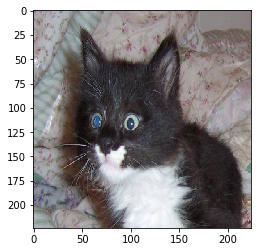

In [29]:
#######################
# 画像の読み込みと予測
#######################
images = transform_img_fn([os.path.join('/content/drive/My Drive/ColabNotebooks/test4ai/data/ImageNet/generated_inputs/occl_wd0.1_wnc0.1_st1.0_sd50_ite50_th0.1_ocst(0, 0)_ocsz(200, 200)_jFn','occl_wd0.1_wnc0.1_st1.0_sd50_ite50_th0.1_ocst(0, 0)_ocsz(200, 200)_dog0.881_cat0.999_cat0.999_9_nc1_0.6566_nc2_0.8310_nc3_0.8310_NY.png')])
images_orig = transform_img_fn([os.path.join('/content/drive/My Drive/ColabNotebooks/test4ai/data/ImageNet/generated_inputs/occl_wd0.1_wnc0.1_st1.0_sd50_ite50_th0.1_ocst(0, 0)_ocsz(200, 200)_jFn','occl_wd0.1_wnc0.1_st1.0_sd50_ite50_th0.1_ocst(0, 0)_ocsz(200, 200)_dog0.881_cat0.999_cat0.999_9_nc1_0.6566_nc2_0.8310_nc3_0.8310_Qi_orig.png')])
preds1 = model1.predict(images)
preds2 = model2.predict(images)
#preds3 = model3.predict(images)
print("model1 : genterated")
for x in decode_predictions(preds1)[0]:
    print(x)

print("=============================================")
print("model2 :  genterated")
for x in decode_predictions(preds2)[0]:
  print(x)

#print("=============================================")
#print("model3 : genterated")
#for x in decode_predictions(preds3)[0]:
#    print(x)


preds1_orig = model1.predict(images_orig)
preds2_orig = model2.predict(images_orig)
#preds3_orig = model3.predict(images_orig)

print("=============================================")
print("model1 : origin")
for x in decode_predictions(preds1_orig)[0]:
    print(x)

print("=============================================")
print("model2 :  origin")
for x in decode_predictions(preds2_orig)[0]:
  print(x)

#print("=============================================")
#print("model3 : origin")
#for x in decode_predictions(preds3_orig)[0]:
#    print(x)


```
plt.imshow(images[0] / 300 + 0.5)
```
 の `300 + 0.5` など数字部分を変更することで、ある程度前処理した画像の見栄えをよくできるので、見栄えが悪い場合はチューニングしてください。


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


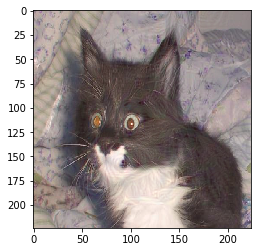

In [21]:
plt.imshow(images[0] / 300 + 0.5)
# plt.imshow(images[0] / 2 + 0.5)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


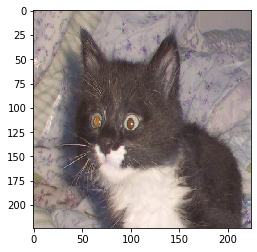

In [22]:

plt.imshow(images_orig[0] / 300 + 0.5)


# LIME のインストール

In [23]:
! pip install lime
%load_ext autoreload
%autoreload 2
import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime
from lime import lime_image

     |████████████████████████████████| 276kB 21.2MB/s 
  Created wheel for lime: filename=lime-0.1.1.37-cp36-none-any.whl size=284277 sha256=f2ff7e0781e23cafb4be686188da0f13af6848819129d94f4426df696aeb0019
  Stored in directory: /root/.cache/pip/wheels/c1/38/e7/50d75d4fb75afa604570dc42f20c5c5f5ab26d3fbe8d6ef27b
  Created wheel for progressbar: filename=progressbar-2.5-cp36-none-any.whl size=12074 sha256=ce756cc5affaef37fcd50fef44cfe21c48dda8811d58570bd1df7869944129b8
  Stored in directory: /root/.cache/pip/wheels/c0/e9/6b/ea01090205e285175842339aa3b491adeb4015206cda272ff0
Successfully built lime progressbar


In [32]:
%%time
explainer = lime_image.LimeImageExplainer()
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
model1_explanation = explainer.explain_instance(images[0], model1.predict, top_labels=5, hide_color=0, num_samples=1000)
model1_explanation_orig = explainer.explain_instance(images_orig[0], model1.predict, top_labels=5, hide_color=0, num_samples=1000)
model2_explanation = explainer.explain_instance(images[0], model2.predict, top_labels=5, hide_color=0, num_samples=1000)
model2_explanation_orig = explainer.explain_instance(images_orig[0], model2.predict, top_labels=5, hide_color=0, num_samples=1000)
#model3_explanation = explainer.explain_instance(images[0], model3.predict, top_labels=5, hide_color=0, num_samples=1000)
#model3_explanation_orig = explainer.explain_instance(images_orig[0], model3.predict, top_labels=5, hide_color=0, num_samples=1000)


CPU times: user 44.7 s, sys: 2.65 s, total: 47.4 s
Wall time: 1min 10s


```
model1_explanation.get_image_and_mask(model1_explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=True)
```
 `positive_only` -> True の場合、判断に寄与したもの（猫なら猫と判断する根拠となったもの）のみを表示、False の場合、判断に寄与したものを緑、寄与しなかったものを赤で表示
 
 `hide_rest` -> True：背景を隠し、判断箇所のみ表示。False：背景と判断箇所両方を表示。


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


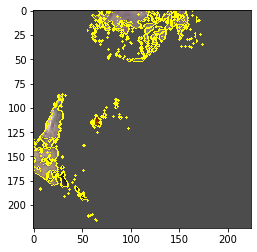

In [43]:
from skimage.segmentation import mark_boundaries
temp, mask = model1_explanation.get_image_and_mask(model1_explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=True)
plt.imshow(mark_boundaries(temp / 200 + 0.3, mask))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


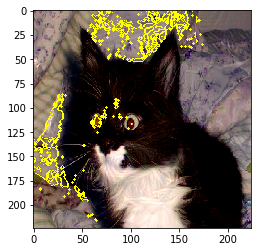

In [34]:
temp, mask = model1_explanation.get_image_and_mask(model1_explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 200 + 0.3, mask))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


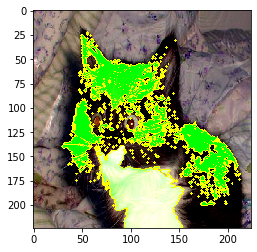

In [27]:
temp, mask = model1_explanation.get_image_and_mask(model1_explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 200 + 0.3, mask))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


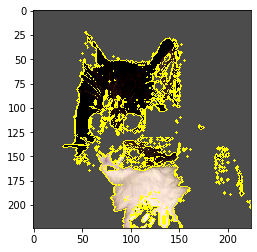

In [35]:
# print("================")
# print("model 1 origine input")
temp, mask = model1_explanation_orig.get_image_and_mask(model1_explanation_orig.top_labels[0], positive_only=True, num_features=10, hide_rest=True)
#plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.imshow(mark_boundaries(temp / 200 + 0.3, mask))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


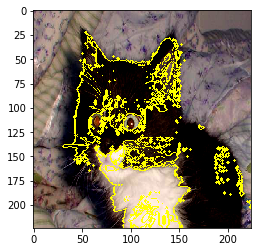

In [36]:
temp, mask = model1_explanation_orig.get_image_and_mask(model1_explanation_orig.top_labels[0], positive_only=True, num_features=10, hide_rest=False)
#plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.imshow(mark_boundaries(temp / 200 + 0.3, mask))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


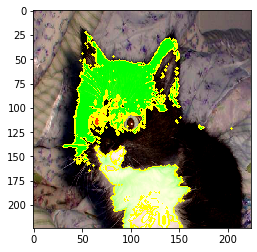

In [42]:

temp, mask = model1_explanation_orig.get_image_and_mask(model1_explanation_orig.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
#plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.imshow(mark_boundaries(temp / 200 + 0.3, mask))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


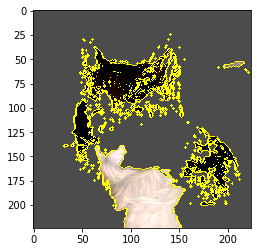

In [37]:
# print("================")
# print("model 2 generated input")
temp, mask = model2_explanation.get_image_and_mask(model2_explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=True)
#plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.imshow(mark_boundaries(temp / 200 + 0.3, mask))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


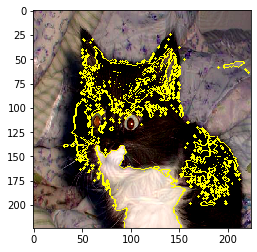

In [38]:
temp, mask = model2_explanation.get_image_and_mask(model2_explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=False)
#plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.imshow(mark_boundaries(temp / 200 + 0.3, mask))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


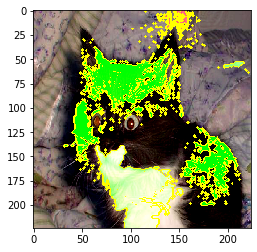

In [39]:
temp, mask = model2_explanation.get_image_and_mask(model2_explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
#plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.imshow(mark_boundaries(temp / 200 + 0.3, mask))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


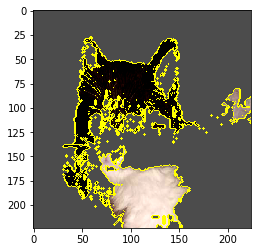

In [40]:
# print("================")
# print("model 2 origine input")
temp, mask = model2_explanation_orig.get_image_and_mask(model2_explanation_orig.top_labels[0], positive_only=True, num_features=10, hide_rest=True)
#plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.imshow(mark_boundaries(temp / 200 + 0.3, mask))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


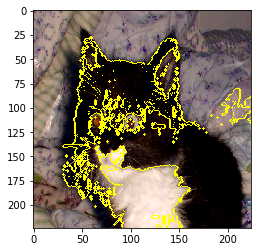

In [44]:
temp, mask = model2_explanation_orig.get_image_and_mask(model2_explanation_orig.top_labels[0], positive_only=True, num_features=10, hide_rest=False)
#plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.imshow(mark_boundaries(temp / 200 + 0.3, mask))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


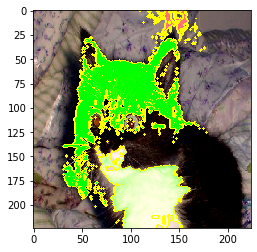

In [41]:
temp, mask = model2_explanation_orig.get_image_and_mask(model2_explanation_orig.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
#plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.imshow(mark_boundaries(temp / 200 + 0.3, mask))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


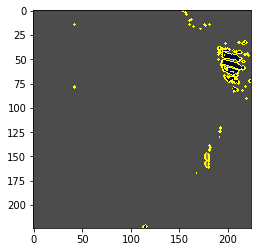

In [0]:
# print("================")
# print("model 3 generated input")
temp, mask = model3_explanation.get_image_and_mask(model3_explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=True)
#plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.imshow(mark_boundaries(temp / 200 + 0.3, mask))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


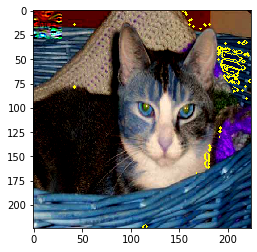

In [0]:
temp, mask = model3_explanation.get_image_and_mask(model3_explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=False)
#plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.imshow(mark_boundaries(temp / 200 + 0.3, mask))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


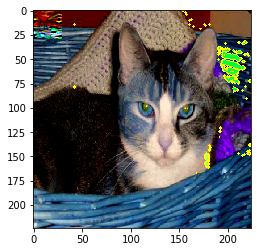

In [0]:
temp, mask = model3_explanation.get_image_and_mask(model3_explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
#plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.imshow(mark_boundaries(temp / 200 + 0.3, mask))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


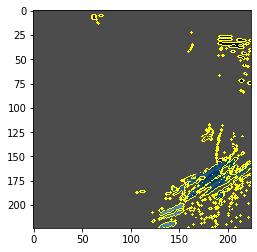

In [0]:
# print("================")
# print("model 3 origine input")
temp, mask = model3_explanation_orig.get_image_and_mask(model3_explanation_orig.top_labels[0], positive_only=True, num_features=10, hide_rest=True)
#plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.imshow(mark_boundaries(temp / 200 + 0.3, mask))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


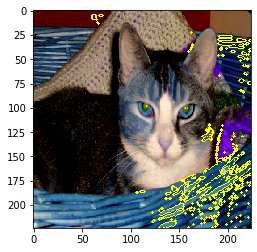

In [0]:
temp, mask = model3_explanation_orig.get_image_and_mask(model3_explanation_orig.top_labels[0], positive_only=True, num_features=10, hide_rest=False)
#plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.imshow(mark_boundaries(temp / 200 + 0.3, mask))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


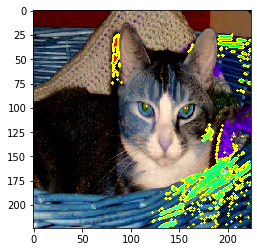

In [0]:
temp, mask = model3_explanation_orig.get_image_and_mask(model3_explanation_orig.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
#plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.imshow(mark_boundaries(temp / 200 + 0.3, mask))
